### 1. Import Libraries

In [1]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
import seaborn as sns

### 2. Readin Data

In [2]:
# transaction table
df_tran = pd.read_table('../data/000_sample1.gz',
                       compression='gzip',
                       sep='\t',
                       quotechar='"',
                       error_bad_lines=False)

In [3]:
# creative table
df_creative = pd.read_table('../data/creatives000',
                       #compression='gzip',
                       sep='|',
                       quotechar='"',
                       error_bad_lines=False,header=None)
df_creative.columns = ['creative_id','created_at','application_id','name','video_id',
                       'is_streaming','language','enforce_language_match','device_type_whitelist',
                      'delivery_frequency_cap','time_to_show_countdown','time_to_show_close_button',
                      'cloudux_template_id']
sys.stdout = stdout

### 3. Join Tables

In [4]:
df_tran['is_install'] = df_tran['timestamp_at_install'].notnull() * 1
df_tran_sub = df_tran.loc[:,['is_install','creative_id','time_of_this_impression']]

In [5]:
df_tran_ad = pd.merge(df_tran_sub, df_creative, how='left', on='creative_id', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

In [6]:
# check NA
df_tran_ad.isnull().sum()

is_install                         0
creative_id                        0
time_of_this_impression            4
created_at                         2
application_id                     2
name                               2
video_id                           2
is_streaming                     157
language                           2
enforce_language_match             2
device_type_whitelist              2
delivery_frequency_cap             2
time_to_show_countdown             2
time_to_show_close_button          2
cloudux_template_id          6960636
dtype: int64

### 4. Add Y & Clean Data

In [7]:
df_tran_ad['language'] = df_tran_ad['language'].apply(lambda x: str(x).lower().split('-')[0])
df_tran_ad['is_install'] = df_tran_ad['is_install'].astype('category')

### 5. Create new features

#### Ad Age

In [8]:
df_tran_ad['time_delta'] = pd.to_datetime(df_tran_ad['time_of_this_impression'])-pd.to_datetime(df_tran_ad['created_at'])
df_tran_ad['time_delta_days'] = df_tran_ad['time_delta'].dt.days

### 5. Continous Variables

In [28]:
def continous_EDA(col,df,dist_xlim=None,box_ylim=None):
    group0 = df[df['is_install']==0][col].dropna()
    group1 = df[df['is_install']==1][col].dropna()
    
    # T-test
    print 't-test'
    p = ttest_ind(group0, group1, axis=0, equal_var=False)
    print p

    # histogram of two groups
    print 'Distribution of two groups'
    fig, ax = plt.subplots()
    i = 0
    for a in [group0, group1]:
        g=sns.distplot(a, ax=ax, kde=False,label=str(i))
        i += 1
    g.set(xlim=(0, dist_xlim))
    ax.legend(loc=2,prop={'size':7})
    plt.show()
    
    # Box-plot
    print 'Box-plot'
    ax = sns.boxplot(x="is_install", y=col, data=df)
    ax.set(ylim=(0, box_ylim))
    plt.show()
    return p.pvalue

-----------Feature: time_delta_days ----------------
t-test
Ttest_indResult(statistic=47.626117270348637, pvalue=0.0)
Distribution of two groups


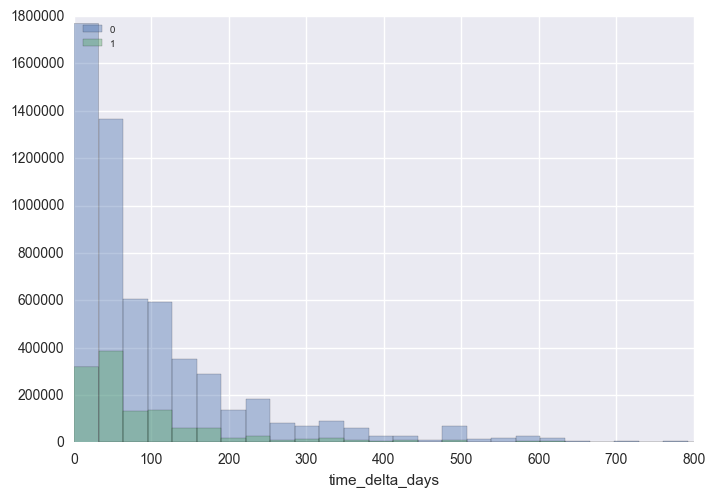

Box-plot


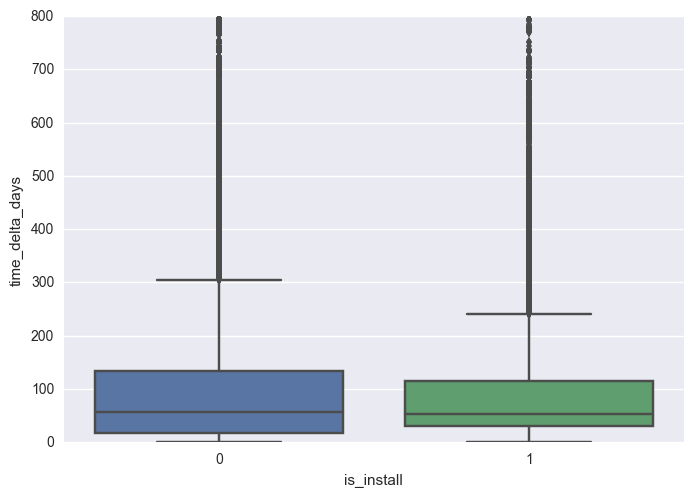

---------------------------------



('significant columns:', ['time_delta_days'])

In [29]:
p_lst = []
cont_cols = ['time_delta_days']
for col in cont_cols:
    print '-----------Feature:', col,'----------------'
    p = continous_EDA(col,df_tran_ad,800,800)
    p_lst.append(p)
    print '---------------------------------\n'

significant_cols = [col for col,p in zip(cont_cols,p_lst) if p<0.05]
'significant columns:', significant_cols

### 6. Categorical Variables

In [15]:
cat_cols = ['is_streaming','language','enforce_language_match','device_type_whitelist',
            'delivery_frequency_cap','time_to_show_countdown','time_to_show_close_button',
            'cloudux_template_id']

-----------Feature: is_streaming ----------------


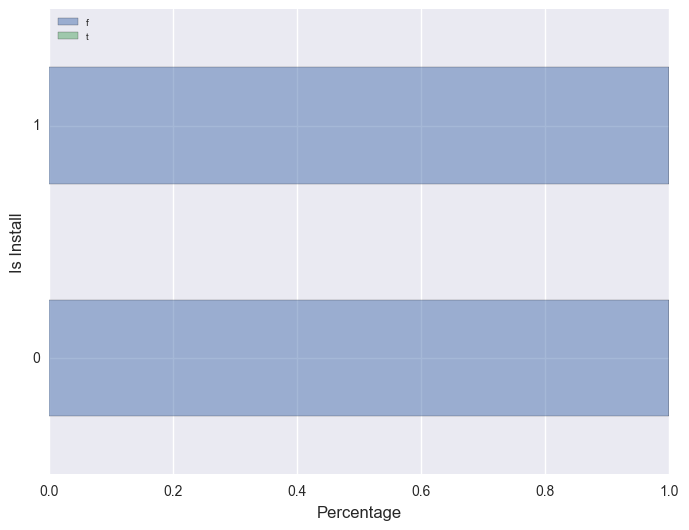

1.66966182179e-106
---------------------------------

-----------Feature: language ----------------


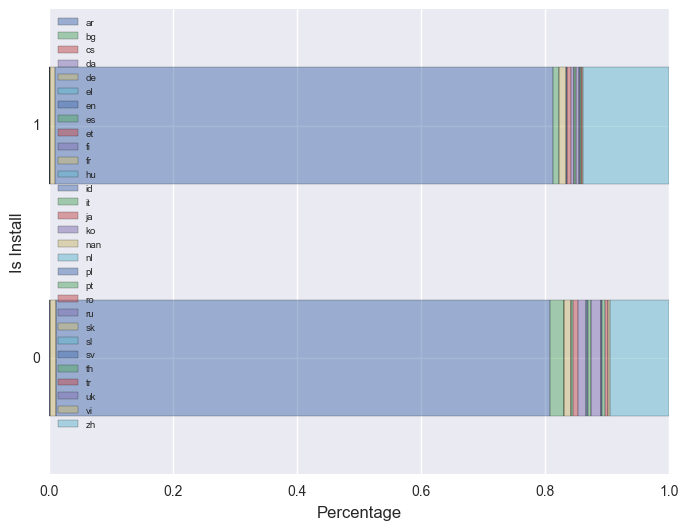

1.0
---------------------------------

-----------Feature: enforce_language_match ----------------


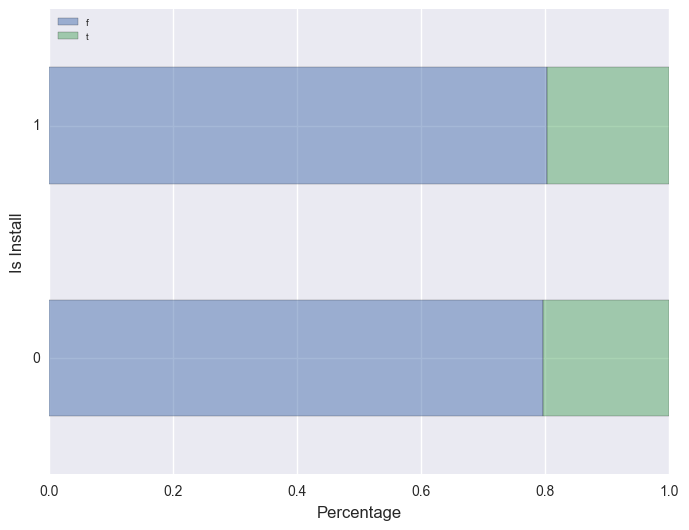

0.079215118523
---------------------------------

-----------Feature: device_type_whitelist ----------------


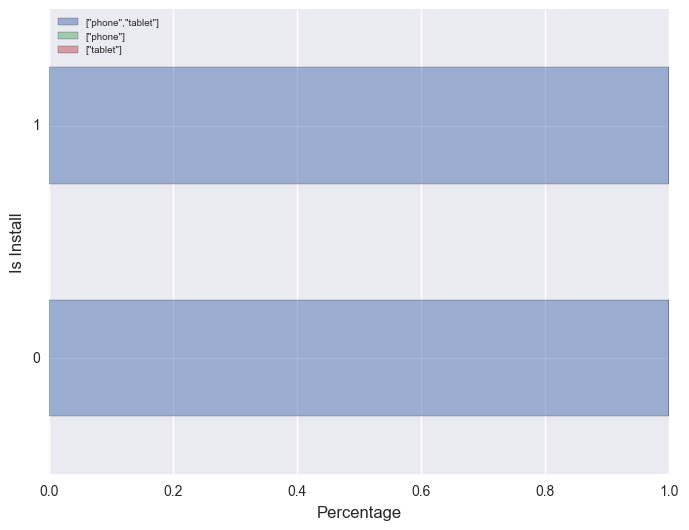

0.999958125092
---------------------------------

-----------Feature: delivery_frequency_cap ----------------


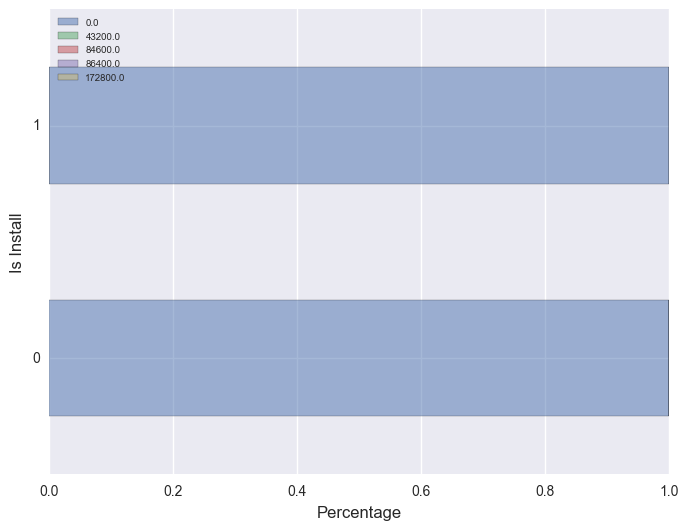

0.999999998577
---------------------------------

-----------Feature: time_to_show_countdown ----------------


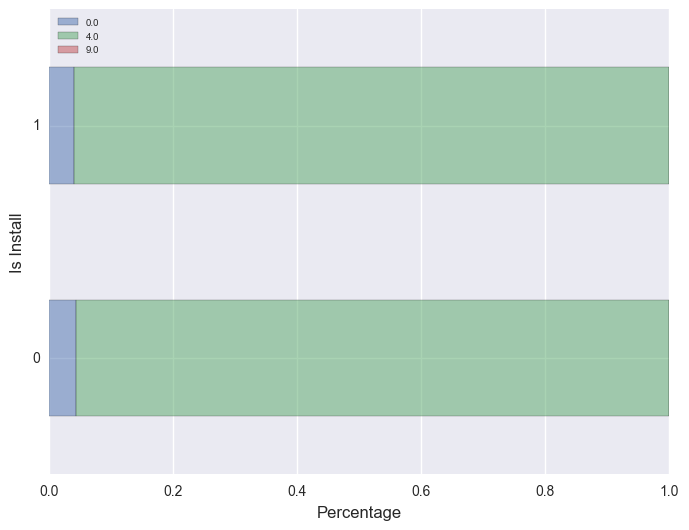

0.999954205992
---------------------------------

-----------Feature: time_to_show_close_button ----------------


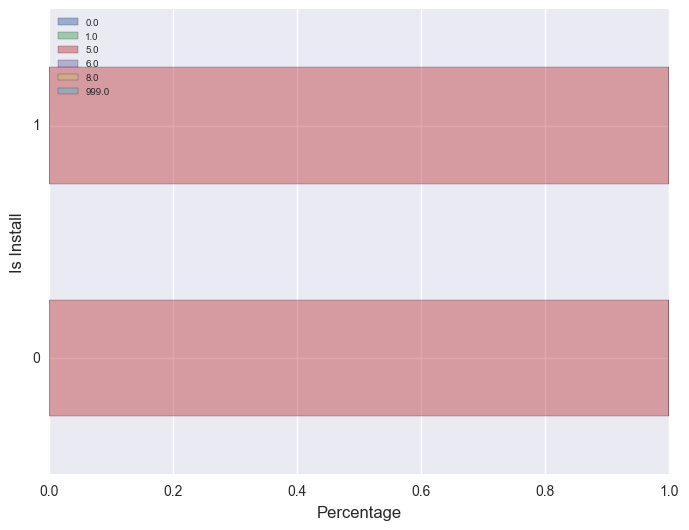

0.999999999999
---------------------------------

-----------Feature: cloudux_template_id ----------------


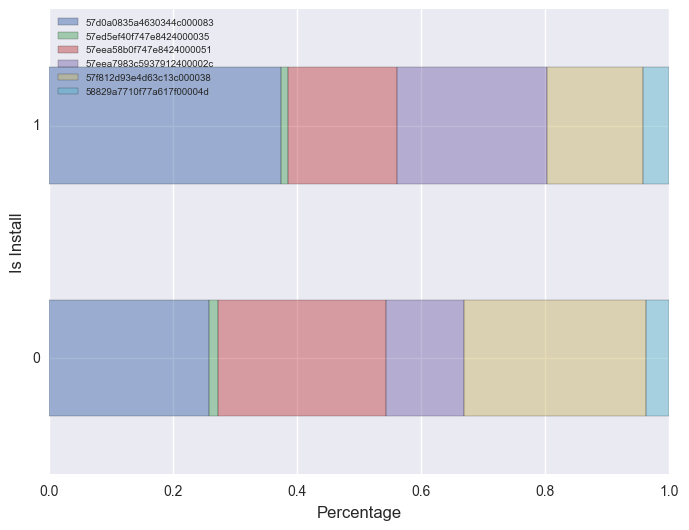

0.999732910281
---------------------------------



('significant columns:', ['is_streaming'])

In [30]:
def categotical_EDA(col, df):
    count = pd.crosstab(df['is_install'],df[col])
    count = count.iloc[:,0:]
    pcts = count.div(count.sum(1).astype(float),axis=0)
    g, p, dof, expctd = chi2_contingency(pcts.as_matrix())
    
    ax = pcts.plot(kind='barh',stacked=True, alpha=0.5, figsize=(8,6))
    ax.set_xlabel("Percentage", fontsize=12)
    ax.set_ylabel("Is Install", fontsize=12)
    ax.legend(loc=2,prop={'size':7})
    
    plt.show()
    print p
    return p

p_lst = []
for col in cat_cols:
    print '-----------Feature:', col,'----------------'
    p = categotical_EDA(col,df_tran_ad)
    p_lst.append(p)
    print '---------------------------------\n'
significant_cols = [col for col,p in zip(cat_cols,p_lst) if p<0.05]
'significant columns:', significant_cols

### 7. Conclusion
Useful Features:
* Continous Variable: ['time_delta_days']
* Categorial Variable: ['is_streaming']
